In [1]:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import html5lib
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Read in all NHL transactions and filter for trades only
df=pd.read_csv("Hockey_trades_final.csv")

In [3]:
#Current NHL teams
teams = {"Ducks":{},
"Coyotes":{},
"Bruins":{},
"Sabres":{},
"Flames":{},
"Hurricanes":{},
"Blackhawks":{},
"Avalanche":{},
"BlueJackets":{},
"Stars":{},
"RedWings":{},
"Oilers":{},
"Panthers":{},
"Kings":{},
"Wild":{},
"Canadiens":{},
"Predators":{},
"Devils":{},
"Islanders":{},
"Rangers":{},
"Senators":{},
"Flyers":{},
"Penguins":{},
"Sharks":{},
"Blues":{},
"Lightning":{},
"MapleLeafs":{},
"Canucks":{},
"GoldenKnights":{},
"Capitals":{},
"Jets":{},
                }

In [4]:
#TODO
#Fix space formating in column 4 xxxx
#Fix data for teams that have moved or changed names xxx
#Split the date columns xxxx
#Variable for players sent/received xxxx

In [5]:
#Build nested dictionary of teams and their trade partners

network_dict = {}

for index, row in df.iterrows():

  #Figure out what season we're in
  year = row['Year']
  if row['Month'] < 7:
    season = f"{year-1} - {year}"
  else:
    season = f"{year} - {year + 1}"
  
  #Loop through teams dictionary and starting finding team A and team B
  a = row["Team A"]
  for team in teams.keys():
    if team in row["Team B"]:
      b=team
      
      '''
      if b=="Senators" or a=="Senators":
        if year < 1992:
          continue
      '''

      if a not in teams.keys():
        continue

      if season not in teams[a].keys():
        teams[a][season]={}
      
      if season not in network_dict.keys():
        network_dict[season] = {}

      if a not in network_dict[season].keys():
        network_dict[season][a] = {}

      if b not in teams[a][season].keys():
        teams[a][season][b] = 1
      else:
        teams[a][season][b] += 1

      if b not in network_dict[season][a].keys():
        network_dict[season][a][b] = 1
      else:
        network_dict[season][a][b] += 1


#For some reason the csv indicated that a team had traded with itself. Remove these
for team in teams:
  if team in teams[team].keys():
    teams[team].pop(team, None)



In [ ]:
network_dict['2018 - 2019']

In [63]:
#Construct the graph
#Edge weights correspond to number of transactions

networks_by_year = {}
year=2010
for i in range(10):
  season_string=f"{year + i} - {year + 1 + i}"

  G = nx.Graph()

  for team in teams.keys():
    G.add_node(team)

  for team_A in network_dict[season_string].keys():
    for team_B in network_dict[season_string][team_A].keys():
      G.add_edge(team_A, team_B, weight=network_dict[season_string][team_A][team_B])
  G.remove_nodes_from(list(nx.isolates(G)))
  networks_by_year[season_string] = G

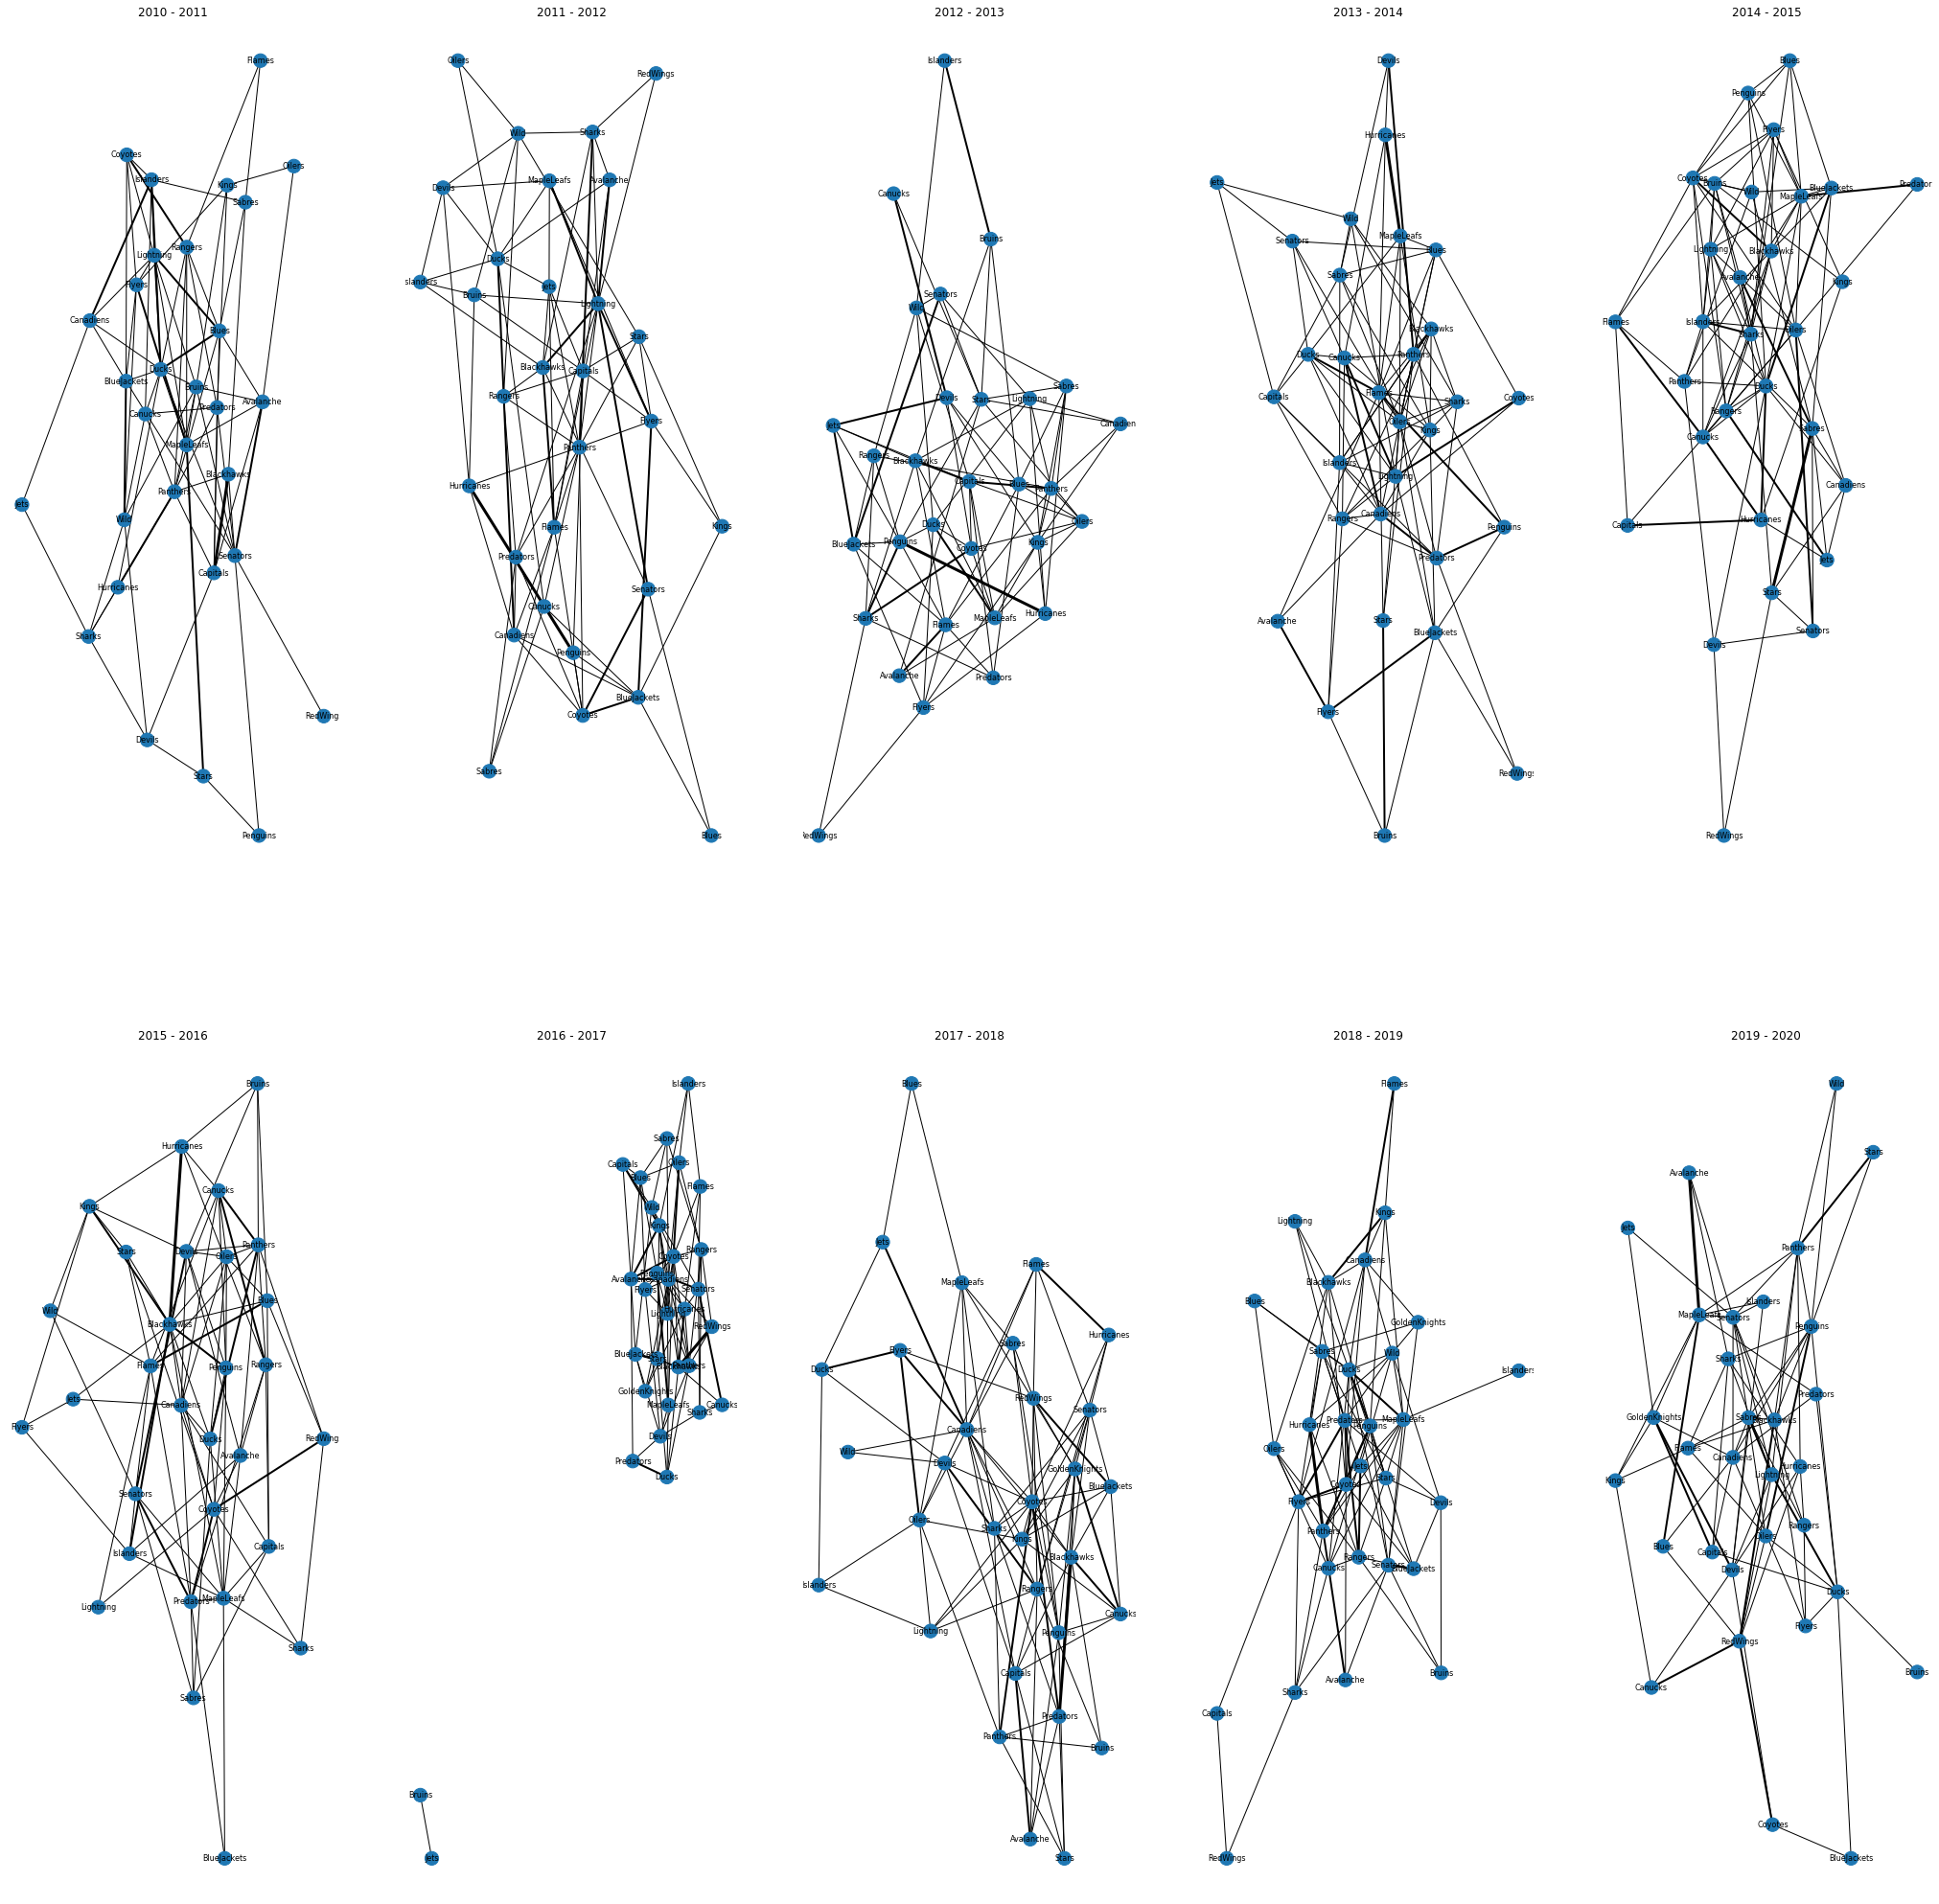

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(36, 36)
ax = axes.flatten()

i=0
for network in networks_by_year:
  d = dict(networks_by_year[network].degree)

  pos = nx.spring_layout(networks_by_year[network])
  nx.draw(networks_by_year[network],ax=ax[i], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
  ax[i].set_axis_off()
  ax[i].set_title(network)
  i+=1

plt.savefig('nhl_networks_10-20.png')

In [69]:
plt.savefig('nhl_networks_10-20.png')

<Figure size 432x288 with 0 Axes>

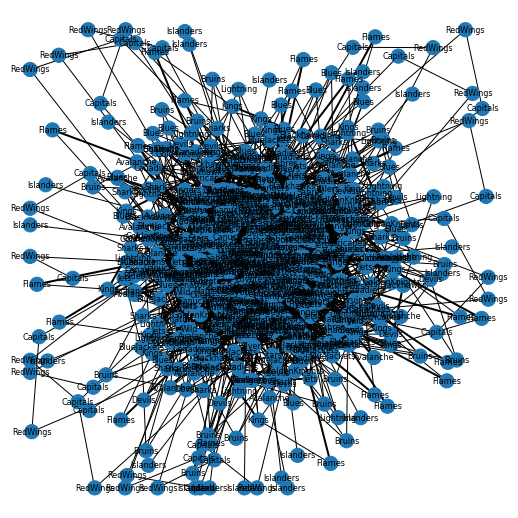

In [37]:
plt.figure(figsize=(7,7))
 
for network in networks_by_year: 

  d = dict(networks_by_year[network].degree)
  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()

  nx.draw(networks_by_year[network], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
plt.show()

In [ ]:
import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(4,5, figsize=(20, 60))
for network in networks_by_year: 
    axs[i][j].scatter(df['target_col'], df[col], s=3)
    axs[i][j].set_ylabel(network)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

In [34]:
import nx_altair as nxa
import altair as alt
%matplotlib inline
import numpy as np

pos = nx.spring_layout(G)


east=[
"Bruins",	"Hurricanes",
"Sabres", "BlueJackets"
"RedWings", "Devils",
"Panthers", "Islanders",
"Canadiens", "Rangers",
"Senators",	 "Flyers",
"Lightning",	 "Penguins",
"MapleLeafs",	 "Capitals"]

# Add attributes to each node.
for n in G.nodes():
    G.nodes[n]['weight'] = np.random.randn()
    G.nodes[n]['name'] = np.random.randint(1000)
    if n in east:
      G.nodes[n]['conference'] = 'East'
    else:
      G.nodes[n]['conference'] = 'West'
    

# Add attributes to edge.    
for e in G.edges():
    G.edges[(e[0],e[1])]['weight'] = np.random.uniform(1, 10)

chart = nxa.draw_networkx(
    G=G,
    pos=pos,
    node_size=200,
    node_color='conference',
    cmap='viridis',
    width='weight',
    node_tooltip=['weight', 'name', 'conference']
)

# Get the node layer
edges = chart.layer[0]
nodes = chart.layer[1]

# Build a brush
brush = alt.selection_interval(encodings=['x', 'y'])
color = alt.Color('conference:N',  legend=None)

# Condition nodes based on brush
nodes = nodes.encode(
    fill=alt.condition(brush, color, alt.value('gray')),
).add_selection(
    brush
)

# Create a bar graph to show highlighted nodes.
bars = alt.Chart(nodes.data).mark_bar().encode(
    x=alt.X('count()', scale=alt.Scale(domain=(0,20))),
    y='conference',
    color='conference',
).transform_filter(
    brush
)

alt.vconcat(edges+nodes, bars)

alt.VConcatChart(...)

In [ ]:
nx.average_shortest_path_length(G)

2.1053763440860216

In [ ]:
page_rank_dict = nx.pagerank(G)
bt_dict = nx.betweenness_centrality(G)

In [ ]:
cups_df=pd.read_csv("stanley_cup_data.csv")

In [ ]:
cups_df.tail()

,Team,Wins,Losses,Win %,Division,Joined League,All GP,All W,All L,All T,All OTL,All Points,All PTS%,Cup Apps,Cup App Seasons,2017 - 2018 Rk,2017-2018 Overall,2017-2018 Shootout,2017-2018 Overtime,2017-2018 Home,2017-2018 Road,2017-2018 EAS,2017-2018 WES,2017-2018 ATL,2017-2018 MET,2017-2018 CEN,2017-2018 PAC,2017-2018 ≤1,2017-2018 ≥3,2017-2018 Oct,2017-2018 Nov,2017-2018 Dec,2017-2018 Jan,2017-2018 Feb,2017-2018 Mar,2017-2018 Apr,2018 - 2019 Rk,2018 - 2019 Overall,2018 - 2019 Shootout,2018 - 2019 Overtime,2018 - 2019 Home,2018 - 2019 Road,2018 - 2019 EAS,2018 - 2019 WES,2018 - 2019 ATL,2018 - 2019 MET,2018 - 2019 CEN,2018 - 2019 PAC,2018 - 2019 ≤1,2018 - 2019 ≥3,2018 - 2019 Oct,2018 - 2019 Nov,2018 - 2019 Dec,2018 - 2019 Jan,2018 - 2019 Feb,2018 - 2019 Mar,2018 - 2019 Apr
26,Sabres,0,2,0.0,East,1970,"3,889","1,790","1,530",409,160,"4,149",0.533,2,"1975, 1999",31,25-45-12,1-2,5-10,11-25-5,14-20-7,16-29-7,9-16-5,11-14-3,5-15-4,3-9-2,6-7-3,11-11-12,4-23-0,3-7-2,3-8-2,4-5-4,4-7-1,6-6-2,5-8-1,0-4-0,27,33-39-10,5-3,7-7,21-15-5,12-24-5,19-25-8,14-14-2,11-12-5,8-13-3,4-9-1,10-5-1,17-9-10,9-19-0,6-4-2,11-3-1,4-6-3,4-6-0,4-7-2,2-12-2,2-1-0
27,Senators,0,1,0.0,North,1992,"2,139",948,912,115,164,"2,175",0.508,1,2007,30,28-43-11,2-7,8-4,16-19-6,12-24-5,17-28-7,11-15-4,10-14-4,7-14-3,5-8-1,6-7-3,17-15-11,7-23-0,5-2-5,3-7-1,4-8-2,3-7-1,6-7-1,6-9-1,1-3-0,31,29-47-6,0-1,6-5,18-19-4,11-28-2,17-32-3,12-15-3,10-16-2,7-16-1,6-7-1,6-8-2,9-11-6,13-26-0,4-5-2,7-7-1,4-9-1,4-5-1,3-11-0,6-7-1,1-3-0
28,Sharks,0,1,0.0,West,1991,"2,218","1,049",892,121,156,"2,375",0.535,1,2016,11,45-27-10,5-3,5-7,25-13-3,20-14-7,16-13-3,29-14-7,8-5-3,8-8-0,8-9-4,21-5-3,18-4-10,17-9-0,6-5-0,7-3-2,7-4-2,6-4-4,8-5-1,10-4-1,1-2-0,6,46-27-9,0-3,8-6,25-11-5,21-16-4,14-13-5,32-14-4,6-8-2,8-5-3,15-6-0,17-8-4,18-5-9,22-14-0,6-3-3,6-6-2,9-4-2,8-3-0,8-3-1,7-7-1,2-1-0
29,Stars,1,4,0.2,Central,1967,"4,115","1,819","1,689",459,148,"4,245",0.516,5,"1981, 1991, 1999, 2000, 2020",19,42-32-8,4-3,5-5,26-12-3,16-20-5,15-9-8,27-23-0,7-4-5,8-5-3,12-14-0,15-9-0,16-5-8,14-16-0,7-5-0,7-5-1,8-5-2,6-4-1,8-4-0,4-8-4,2-1-0,15,43-32-7,1-2,6-5,24-14-3,19-18-4,15-15-2,28-17-5,9-5-2,6-10-0,14-10-2,14-7-3,17-10-7,15-13-0,6-5-0,7-5-3,7-6-1,5-5-0,7-6-1,9-4-2,2-1-0
30,Wild,0,0,0.0,West,2000,"1,511",724,583,55,149,"1,652",0.547,0,0,8,45-26-11,3-3,4-8,27-6-8,18-20-3,20-8-4,25-18-7,10-5-1,10-3-3,13-12-1,12-6-6,12-4-11,20-14-0,4-4-2,8-6-1,8-6-0,7-2-2,9-2-2,7-5-3,2-1-1,21,37-36-9,1-4,3-5,16-18-7,21-18-2,14-14-4,23-22-5,9-6-1,5-8-3,12-10-4,11-12-1,18-9-9,11-20-0,7-3-2,7-6-0,4-8-1,8-4-0,5-6-3,5-7-3,1-2-0


In [ ]:
'''
for index, row in cups_df.iterrows():
  team = row['Team']
  teams[team]['cup_appearances'] = row['Cup Apps']
  teams[team]['cup_wins'] = row['Wins']
  teams[team]['cup_losses'] = row['Losses']
  teams[team]['cup_win_pct'] = row['Win %']
  teams[team]['Division'] = row['Division']
  teams[team]['All PTS%'] = row['All PTS%']
'''

In [ ]:
team_idx=['Avalanche',
'Blackhawks',
'BlueJackets',
'Blues',
'Bruins',
'Canadiens',
'Canucks',
'Capitals',
'Coyotes',
'Devils',
'Ducks',
'Flames',
'Flyers',
'GoldenKnights',
'Hurricanes',
'Islanders',
'Jets',
'Kings',
'Lightning',
'MapleLeafs',
'Oilers',
'Panthers',
'Penguins',
'Predators',
'Rangers',
'RedWings',
'Sabres',
'Senators',
'Sharks',
'Stars',
'Wild']

In [ ]:
page_rank_list=[value for value in page_rank_dict.values()]
bt_list=[value for value in bt_dict.values()]

rk_list = []
cup_win_pct_list = []
win_pct_list = []

for key in page_rank_dict:
  rk_list.append(cups_df['2018 - 2019 Rk'][team_idx.index(key)])

for key in page_rank_dict:
  record = cups_df['2018 - 2019 Overall'][team_idx.index(key)].split('-')
  record = [int(x) for x in record]
  win_pct = record[0] / sum(record)
  win_pct_list.append(win_pct)


#for key in page_rank_dict:
#  cup_win_pct_list.append(teams[key]["cup_win_pct"])  

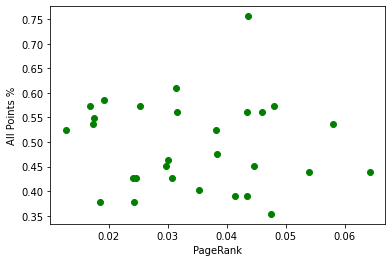

In [ ]:
plt.xlabel("PageRank")
plt.ylabel("All Points %")
#plt.scatter(x=page_rank_list, y=all_pts_pct_list, color='red')
#plt.scatter(x=page_rank_list, y=cup_win_pct_list, color='blue')
plt.scatter(x=page_rank_list, y=win_pct_list, color='green')
#plt.scatter(x=bt_list, y=cup_win_pct_list, color='pink')

In [ ]:
from scipy.stats import pearsonr
corr, _ = pearsonr(win_pct_list,page_rank_list)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.065


In [ ]:
from networkx.algorithms import community
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(G))
sorted(c)

[frozenset({'BlueJackets',
            'Bruins',
            'Devils',
            'GoldenKnights',
            'Hurricanes',
            'Jets',
            'Predators',
            'Rangers',
            'Sabres',
            'Stars',
            'Wild'}),
 frozenset({'Blackhawks',
            'Canadiens',
            'Coyotes',
            'Ducks',
            'Flames',
            'Kings',
            'Lightning',
            'Penguins'}),
 frozenset({'Blues',
            'Canucks',
            'Capitals',
            'Flyers',
            'Oilers',
            'RedWings',
            'Sharks'}),
 frozenset({'Avalanche', 'Islanders', 'MapleLeafs', 'Panthers', 'Senators'})]